In [1]:
import warnings
import re
import copy
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from math import sqrt
from tabulate import tabulate
from plotly.offline import iplot
from plotly.subplots import make_subplots
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr, spearmanr
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [2]:
df = pd.read_csv('test_data.csv', encoding='latin-1',low_memory=False)

In [3]:
df.head()

,PRICE,OLD/NEW,DURATION,TOWN/CITY,Year,Month,Property_Type__D,Property_Type__F,Property_Type__S,Property_Type__T
0,34250,0,0,1.0,1996,2,0,0,0,1
1,49500,0,0,1.0,1999,4,0,0,1,0
2,225000,0,0,1.0,2010,4,1,0,0,0
3,87000,0,0,1.0,1996,11,1,0,0,0
4,20000,0,0,1.0,1996,8,0,0,0,1


In [4]:
print(df.shape)

(5474, 10)


In [5]:
#FEATURE SELECTION
# Split data into features and target variable
X = df.drop('PRICE', axis=1)
y = df["PRICE"]

In [6]:
#SPLITTING AND MODEL SELECTION WITH HYPERPARAMETER TUNING

# Train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Define efficient parameters for each model
rf_params = {
    "n_estimators": 200,
    "max_depth": 8,
    "min_samples_split": 2
}

knn_params = {
    "n_neighbors": 5,
    "weights": "distance",
    "p": 2
}

gb_params = {
    "learning_rate": 0.1,
    "n_estimators": 200,
    "max_depth": 3
}

svr_params = {
    "kernel": "linear",
    "C": 1000,
    "epsilon": 0.05
}

# Initialize models with efficient parameters
random_forest = RandomForestRegressor(**rf_params)
knn = KNeighborsRegressor(**knn_params)
gradient_boosting = GradientBoostingRegressor(**gb_params)
svr = SVR(**svr_params)

In [8]:
# List of models
models = [random_forest, knn, gradient_boosting, svr]

# Initialize lists to store results
results = []

In [9]:
# Evaluate models using cross-validation
for model in models:
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs = -1)
    cv_rmse_scores = [sqrt(-score) for score in cv_scores]  # Convert negative MSE to RMSE
    
    # Calculate mean RMSE and R2 from cross-validation scores
    mean_cv_rmse = sum(cv_rmse_scores) / len(cv_rmse_scores)
    
    # Train the model on full training set
    model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = model.predict(X_test)
    test_rmse = sqrt(mean_squared_error(y_test, y_pred))
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.append({
        'Model': model.__class__.__name__,
        'Mean CV RMSE': mean_cv_rmse,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test R2': test_r2
    })

In [10]:
# Create DataFrame for results
results_df = pd.DataFrame(results)

# Print results table
print("Model Comparison:")
display(results_df)


Model Comparison:


,Model,Mean CV RMSE,Test RMSE,Test MSE,Test R2
0,RandomForestRegressor,71111.032046,73271.570644,5.368723e+09,0.449970
1,KNeighborsRegressor,82404.739675,81527.624455,6.646754e+09,0.319035
2,GradientBoostingRegressor,67917.937771,71396.311103,5.097433e+09,0.477764
3,SVR,74914.399054,80513.081364,6.482356e+09,0.335878


In [11]:
# Select best performing model based on mean CV RMSE
best_model_idx = results_df['Mean CV RMSE'].idxmin()
best_model_idx = results_df['Test RMSE'].idxmin()
best_model_idx = results_df['Test MSE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"\nBest Fit Model: {best_model_name}")



Best Fit Model: GradientBoostingRegressor


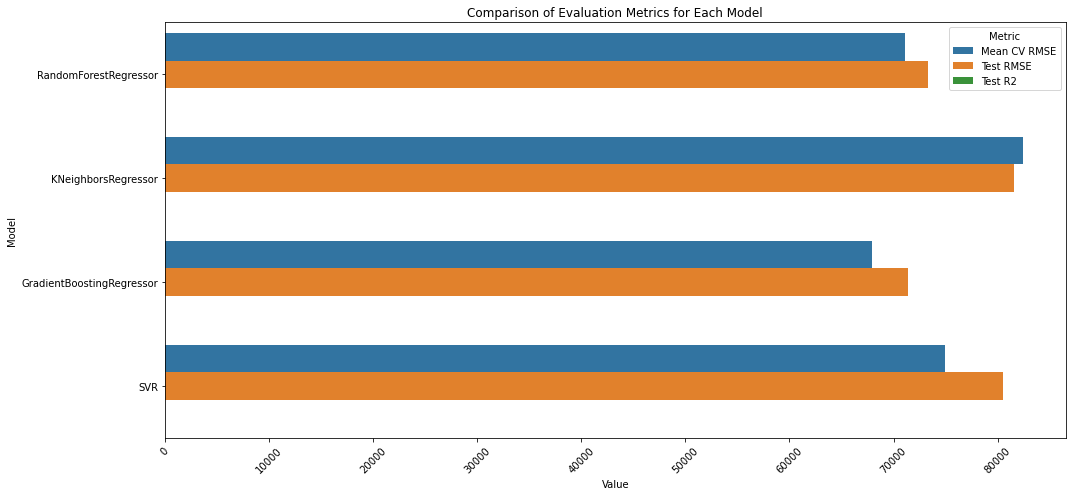

In [12]:
# Combine plots into a single barplot
plt.figure(figsize=(15, 7))

# Melt the DataFrame to reshape it properly
melted_df = pd.melt(results_df, id_vars=['Model'], value_vars=['Mean CV RMSE', 'Test RMSE', 'Test R2'], 
                    var_name='Metric', value_name='Value')

# Plotting Mean CV RMSE, Test RMSE, and Test R2 in a single barplot
sns.barplot(x='Value', y='Model', hue='Metric', data=melted_df)
plt.title('Comparison of Evaluation Metrics for Each Model')
plt.xlabel('Value')
plt.ylabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()
